<a href="https://colab.research.google.com/github/georgezefko/Recommender_System/blob/main/ABA_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from nltk import sent_tokenize
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
path = '/content/drive/MyDrive/AdvancedBA/Olie_data/archive' #adust this one to yours
customers = pd.read_csv(path +'/olist_customers_dataset.csv')
reviews = pd.read_csv(path+'/olist_order_reviews_dataset.csv')
geolocation = pd.read_csv(path+'/olist_geolocation_dataset.csv')
items = pd.read_csv(path + '/olist_order_items_dataset.csv')
payments  = pd.read_csv(path + '/olist_order_payments_dataset.csv')
orders= pd.read_csv(path + '/olist_orders_dataset.csv')
products = pd.read_csv(path + '/olist_products_dataset.csv')
sellers =pd.read_csv(path + '/olist_sellers_dataset.csv')
category =  pd.read_csv(path + '/product_category_name_translation.csv')


In [3]:
#merge datasets

data = pd.merge(orders,customers,on='customer_id')
data = pd.merge(data,reviews,on='order_id')
data = pd.merge(data,payments,on='order_id')
data = pd.merge(data,items,on='order_id')
data = pd.merge(data,products,on='product_id')
data = pd.merge(data,sellers,on='seller_id')
data = pd.merge(data,geolocation,left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')
data = pd.merge(data, category,on ='product_category_name')
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1,credit_card,1,18.12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,9350,-23.680114,-46.452454,maua,SP,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1,credit_card,1,18.12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,9350,-23.675223,-46.441038,maua,SP,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1,credit_card,1,18.12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,9350,-23.685712,-46.444796,mauá,SP,housewares
3,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1,credit_card,1,18.12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,9350,-23.679951,-46.448247,maua,SP,housewares
4,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1,credit_card,1,18.12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,9350,-23.678662,-46.442578,maua,SP,housewares


In [4]:

#check for null values (values shown as percentage) Note: it requires high RAM
round(data.isnull().sum()/len(data)*100,2)


order_id                          0.00
customer_id                       0.00
order_status                      0.00
order_purchase_timestamp          0.00
order_approved_at                 0.01
order_delivered_carrier_date      1.04
order_delivered_customer_date     2.13
order_estimated_delivery_date     0.00
customer_unique_id                0.00
customer_zip_code_prefix          0.00
customer_city                     0.00
customer_state                    0.00
review_id                         0.00
review_score                      0.00
review_comment_title             88.45
review_comment_message           57.10
review_creation_date              0.00
review_answer_timestamp           0.00
payment_sequential                0.00
payment_type                      0.00
payment_installments              0.00
payment_value                     0.00
order_item_id                     0.00
product_id                        0.00
seller_id                         0.00
shipping_limit_date      

In [5]:
#choose columns to explore relevant to recommender system

recommender = data[['review_score','price','customer_state','order_status','seller_state','order_item_id','product_category_name_english']]

In [5]:
recommender.head()

,review_score,price,customer_state,customer_zip_code_prefix,order_status,seller_state,order_item_id,product_category_name_english
0,4,29.99,SP,3149,delivered,SP,1,housewares
1,4,29.99,SP,3149,delivered,SP,1,housewares
2,4,29.99,SP,3149,delivered,SP,1,housewares
3,4,29.99,SP,3149,delivered,SP,1,housewares
4,4,29.99,SP,3149,delivered,SP,1,housewares


In [14]:
recommender.isnull().sum()

review_score                     0
price                            0
customer_state                   0
customer_zip_code_prefix         0
order_status                     0
seller_state                     0
order_item_id                    0
product_category_name_english    0
dtype: int64

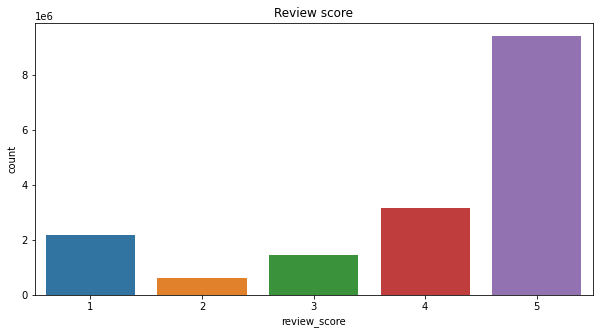

In [30]:
plt.figure(figsize=(10,5))
sns.countplot(x=recommender['review_score'])
plt.title('Review score')
plt.show()

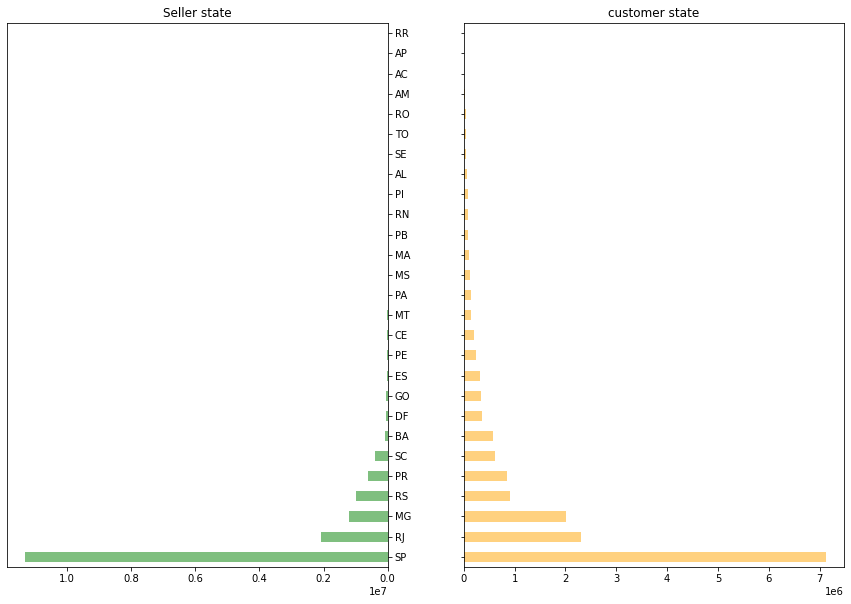

In [9]:

fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15,10))

ax.invert_xaxis()
ax.yaxis.tick_right()

recommender['seller_state'].value_counts().plot(kind='barh', x='LABEL',  legend=False, ax=ax,title = 'Seller state', facecolor = 'green',alpha=0.5)
recommender['customer_state'].value_counts().plot(kind='barh', x='LABEL',ax=ax2, title = 'customer state',facecolor ='orange',alpha=0.5)
plt.show()

In [ ]:
#plots by review

In [116]:
def by_review(df):
  fields = df.columns.tolist()
  colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', '#7f7f7f']
  labels = ['1', '2', '3', '4','5']

  # figure and axis
  fig, ax = plt.subplots(1, figsize=(15, 15))
  # plot bars
  left = len(df) * [0]
  for idx, name in enumerate(fields):
      plt.barh(df.index, df[name], left = left, color=colors[idx])
      left = left + df[name]
  # title, legend, labels
  plt.title(df.index.name, loc='left')
  plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
  plt.xlabel('No of reviews')
  # remove spines
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  # adjust limits and draw grid lines
  plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
  ax.set_axisbelow(True)
  ax.xaxis.grid(color='gray', linestyle='dashed')
  plt.show()

In [112]:

df_seller = recommender.groupby(['seller_state', 'review_score']).size().unstack()
df_seller.fillna(0,inplace=True)
df_seller = df_seller.sort_values(df_seller.columns.tolist()[4], ascending=True)

In [113]:
df_customer = recommender.groupby(['customer_state', 'review_score']).size().unstack()
df_customer.fillna(0,inplace=True)
df_customer = df2.sort_values(df_customer.columns.tolist()[4], ascending=True)

In [114]:
df_products = recommender.groupby(['product_category_name_english', 'review_score']).size().unstack()
df_products.fillna(0,inplace=True)
df_products = df_products.sort_values(df_products.columns.tolist()[4], ascending=True)

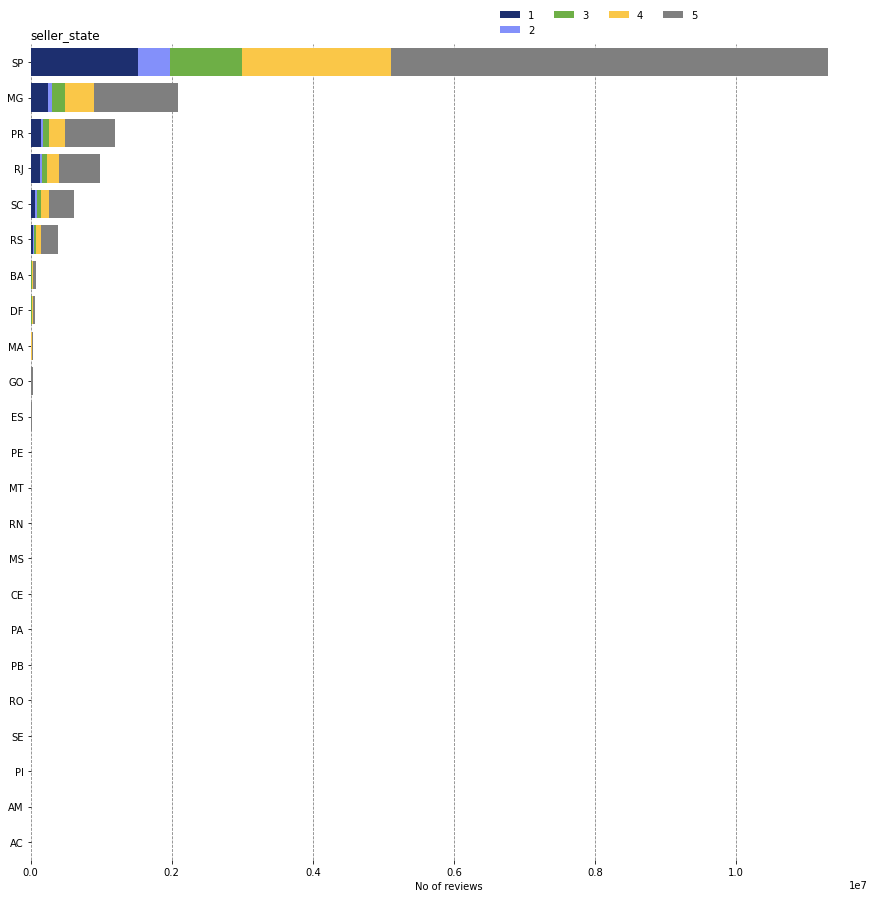

In [117]:
by_review(df_seller)

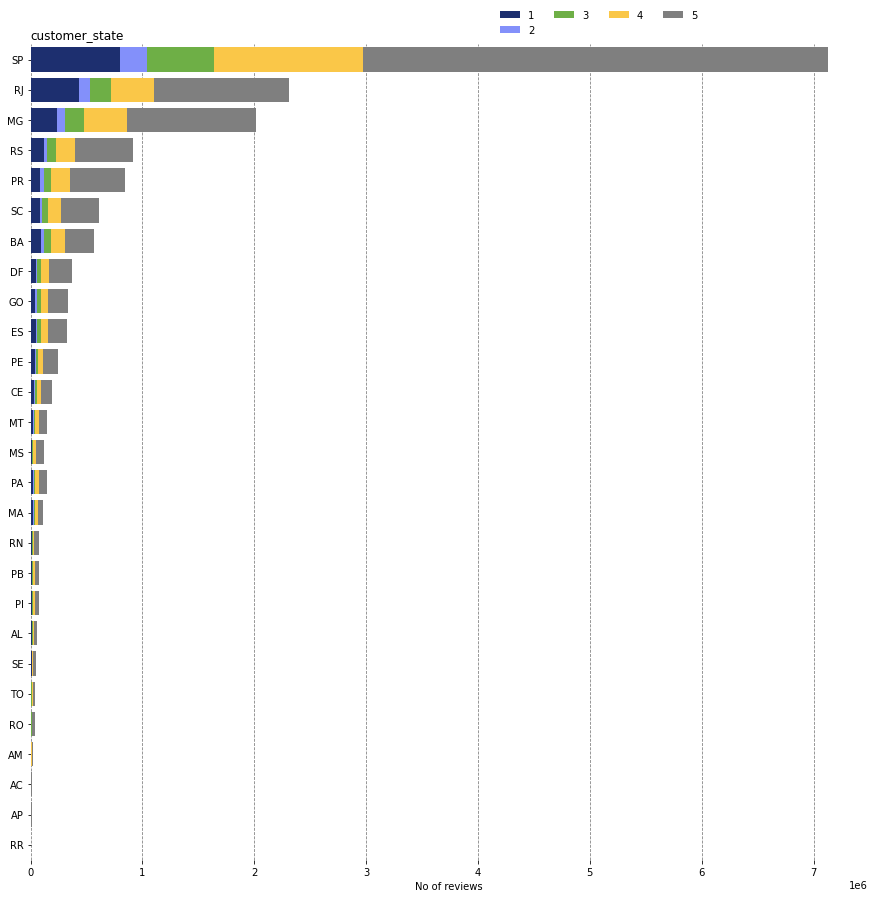

In [118]:
by_review(df_customer)

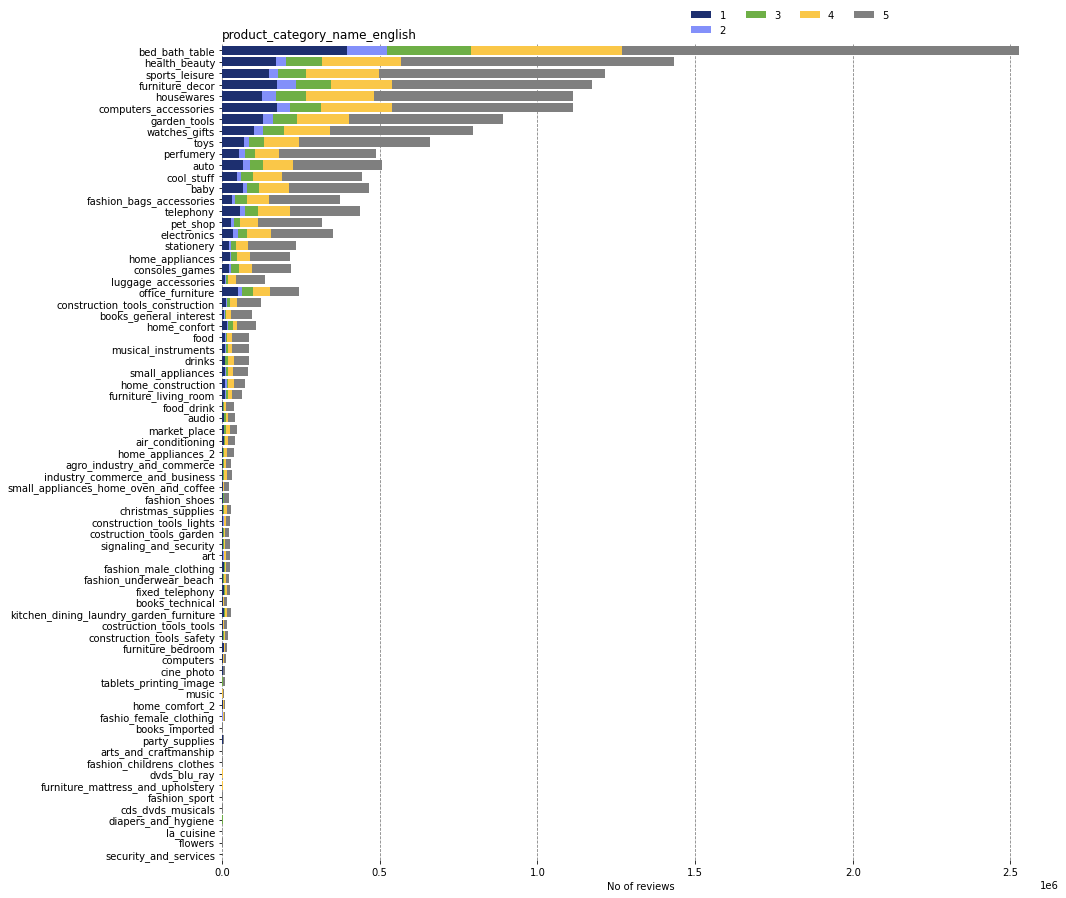

In [120]:
by_review(df_products)